<a href="https://colab.research.google.com/github/physicaone/loss_IG/blob/master/%5B211022%5Dmq_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import torch
import torchvision.datasets
import torchvision.models
import torchvision.transforms
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.utils.data
import torch.nn as nn
from tqdm import tqdm, tnrange
import warnings
warnings.filterwarnings("ignore")
import random
import pickle as pkl
import pandas as pd
from scipy.stats import entropy
CUDA = torch.cuda.is_available()
CUDA_DEVICE = 0

try:
    from google.colab import drive
    drive.mount('/content/drive')
    base='drive/MyDrive'
except:
    if torch.cuda.device_count()>1:
        base='.'
    else:
        base='Google Drive'

if CUDA:
    device='cuda'
else:
    device='cpu'
torch.cuda.is_available()

Mounted at /content/drive


False

In [9]:
def decimal_to_binary(integer, n_hid):
    string=bin(int(integer))[2:]
    list0=[float(d) for d in string]
    while len(list0)<n_hid:
        list0=[0.]+list0
    return torch.tensor([list0])

def binary_to_decimal(list0):
    value=0
    list0=list0.tolist()
    for i in range(len(list0)):
        value+=list0[-i-1]*2**(i)
    return int(value)

def Ising_energy(v_list):
    L = 3
    E_list=[]
    for n in range(len(v_list)):
        v=v_list[n]
        E = 0
        for i in range(L):
            for j in range(L):
                s = v[i,j]
                neigh = v[(i+1)%L, j] + v[i,(j+1)%L] + v[(i-1)%L,j] + v[i,(j-1)%L] 
                E += -neigh * s
        E_list.append(E/2)
    return np.array(E_list)
    
class RBM(nn.Module):

    def __init__(self, n_vis, n_hid, k):
        """Create a RBM."""
        super(RBM, self).__init__()
        
        self.v_bias = nn.Parameter(torch.ones(1, n_vis).to(device))
        self.h_bias = nn.Parameter(torch.zeros(1, n_hid).to(device))
        self.Weight = nn.Parameter(torch.randn(n_hid, n_vis).to(device))
        self.k = k


    def v2h(self, v, beta):
        return torch.sigmoid(F.linear(v, self.Weight, self.h_bias)*beta).detach()

    def h2v(self, h, beta):
        return torch.sigmoid(F.linear(h, self.Weight.t(), self.v_bias)*beta).detach()
    
    def Fv(self, v):
        v_term = torch.matmul(v, self.v_bias.t()).view(len(v)).detach()
        h_term = torch.sum(F.softplus(F.linear(v, self.Weight, self.h_bias)), dim=1).detach()
        return -h_term -v_term

    def energy(self, v, h):
        v=v.bernoulli().detach()
        h=h.bernoulli().detach()
        return -torch.matmul(v, self.v_bias.t())-torch.matmul(torch.matmul(v, self.Weight.t()),h.t())-torch.matmul(h, self.h_bias.t()).detach()
    
    def Energy_GPU2(self, v_list0, h_list0):
        if CUDA:
            n_split=torch.cuda.device_count()
        else:
            n_split=1
        e_list=[]
        m_split=4
        for j in range(m_split):
            v_list1=torch.stack(list(v_list0[j*int(len(v_list0)/m_split):(j+1)*int(len(v_list0)/m_split)])).detach()
            h_list1=torch.stack(list(h_list0[j*int(len(h_list0)/m_split):(j+1)*int(len(h_list0)/m_split)])).detach()
            vs=[]
            hs=[]
            for i in range(n_split):
                v_list2=torch.stack(list(v_list1[i*int(len(v_list1)/n_split):(i+1)*int(len(v_list1)/n_split)])).detach()
                h_list2=torch.stack(list(h_list1[i*int(len(h_list1)/n_split):(i+1)*int(len(h_list1)/n_split)])).detach()
                if CUDA:
                    v_list2=v_list2.to(device='cuda:' + str(i)).view(len(v_list2), n_vis)
                    h_list2=h_list2.to(device='cuda:' + str(i)).view(len(h_list2), n_hid)
                else:
                    None
                vs.append(v_list2)
                hs.append(h_list2)
            for i in range(n_split): 
                if CUDA:
                    a=self.v_bias.to(device='cuda:' + str(i)).view(n_vis)
                    b=self.h_bias.to(device='cuda:' + str(i)).view(n_hid)
                    W=self.Weight.to(device='cuda:' + str(i)).view(n_hid, n_vis)
                    e=(-torch.matmul(vs[i].float(), a)-torch.diagonal(torch.matmul(torch.matmul(vs[i].float(), W.t()), hs[i].float().t()))-torch.matmul(hs[i].float(), b)).to('cuda:0')
                    e_list.append(e)
                else:
                    a=self.v_bias.view(n_vis)
                    b=self.h_bias.view(n_hid)
                    W=self.Weight.view(n_hid, n_vis)
                    e=(-torch.matmul(vs[i].float(), a)-torch.diagonal(torch.matmul(torch.matmul(vs[i].float(), W.t()), hs[i].float().t()))-torch.matmul(hs[i].float(), b))
                    e_list.append(e)
        return torch.stack(e_list).view(len(v_list0)).detach()
    
# 이 함수는 PT에 사용되는 transition 확률을 계산합니다.
def swap_prob(i,j, model, list00, list11):
    v1=torch.tensor(list00[i]).view(1,n_vis)
    v2=torch.tensor(list00[j]).view(1,n_vis)
    h1=torch.tensor(list11[i]).view(1,n_hid)
    h2=torch.tensor(list11[j]).view(1,n_hid)
    beta1=beta_list[i]
    beta2=beta_list[j]
    return torch.exp((beta2-beta1)*(model.energy(v2, h2)-model.energy(v1, h1)))

# 이 함수는 tansition 확률에 의거, swap을 수행합니다.
def swap(list0, list1, model):
    k=np.random.randint(0, len(list0)-1)
    combination=[k, k+1]
    if swap_prob(combination[0], combination[1], model, list0, list1)>=np.random.rand():
        a=list0[combination[0]].clone()
        b=list0[combination[1]].clone() 
        list0[combination[0]]=b
        list0[combination[1]]=a
        
        c=list1[combination[0]].clone()
        d=list1[combination[1]].clone() 
        list1[combination[0]]=d
        list1[combination[1]]=c
    else: None
#     return list0, list1
#     combinations=list(itertools.combinations(list(range(len(list0))), 2))
#     for k in range(len(combinations)):
#         if swap_prob(combinations[k][1], combinations[k][0])>=np.random.rand():
#             list0[combinations[k][0]]=list0[combinations[k][1]]; list0[combinations[k][1]]=list0[combinations[k][0]]
#         else: None
#     return list0

def P_h(list0):
    config_count={}
    for i in range(len(list0)):
        config_count[str(list0[i])]=0
    for i in range(len(list0)):
        config_count[str(list0[i])]+=1
    return config_count

def prod(L):
    p=1
    for i in L:
        p= i * p
    return p

# def Estimate_Z(model0, states):
#     Z=0
#     for i in range(len(states[0])):
#         Z+=torch.exp(-model0.energy2(states[0][i], states[1][i])).detach()
#     return float(Z.detach().numpy())

def get_hist(list00, color='red'):
    bins=range(int(min(list00)-30), int(max(list00)+30), 1)
    y1,x1,_ = plt.hist(list00, bins = bins, histtype='step', color=color)
    x1 = 0.5*(x1[1:]+x1[:-1])
    return x1, y1

def flatten_list(list0):
    flattened = [val for sublist in list0 for val in sublist]
    return flattened


In [116]:

def Entropy(fullconfigs):
    config_count={} # 각 hidden layer state 갯수 파악 (k)
    for i in range(len(fullconfigs)):
        config_count[str(fullconfigs[i])]=0
    for i in range(len(fullconfigs)):
        config_count[str(fullconfigs[i])]+=1

    listk=[]
    for i in range(len(list(config_count.values()))):
        listk.append(int(list(config_count.values())[i]))
    listmk=[]
    kcount={} # 갯수의 갯수 파악 (m_k)
    for i in range(len(listk)):
        kcount[listk[i]]=0
    for i in range(len(listk)):
        kcount[listk[i]]+=1
    for i in range(len(kcount)):
        listmk.append(kcount[sorted(list(kcount))[i]])
    x,y= sorted(list(kcount)), listmk

    N=len(fullconfigs)
    H_s=0
    for i in range(len(x)):
        H_s-=(x[i]*y[i]/N)*np.log(x[i]/N)
    return H_s
def Energy(model0_dict, v_list, h_list):
    a=model0_dict['v_bias'].detach()
    b=model0_dict['h_bias'].detach()
    W=model0_dict['Weight'].detach()
    values=[]
    for i in range(len(v_list)):
        e=-np.matmul(v_list[i], a.t())-np.matmul(np.matmul(v_list[i], W.t()), h_list[i].t())-np.matmul(h_list[i], b.t())
        values.append(e.detach())
    return float(np.mean(values))
    
# function to save every T samples
def sampling_with_PT(fullmodel, eq_step, n_step):
    # states for full model
    hidden_states_now=[decimal_to_binary(2**n_hid-1, n_hid)]*len(beta_list)
    visible_states_now=[1.]*len(beta_list)

    hidden_list=[]
    visible_list=[]
    
    # equilibrium steps for full model
    for step in range(eq_step):
        for i in range(len(beta_list)):
            visible_states_now[i]=fullmodel.h2v(hidden_states_now[i].to(device), beta_list[i]).bernoulli().detach()
            hidden_states_now[i]=fullmodel.v2h(visible_states_now[i].to(device), beta_list[i]).bernoulli().detach()

    # Tasks with PT
    for step in range(n_step):
        hidden_tmp=[]
        visible_tmp=[]
        for i in range(len(beta_list)):
            # Gibbs sampling of fu
            visible_states_now[i]=fullmodel.h2v(hidden_states_now[i].to(device), beta_list[i]).bernoulli().detach()
            hidden_states_now[i]=fullmodel.v2h(visible_states_now[i].to(device), beta_list[i]).bernoulli().detach()

            hidden_tmp.append(np.array(hidden_states_now[i].view(n_hid)))
            visible_tmp.append(np.array(visible_states_now[i].view(n_vis)))
        swap(visible_states_now, hidden_states_now, fullmodel)
        hidden_list.append(hidden_tmp)
        visible_list.append(visible_tmp)
    return visible_list, hidden_list

def Curly_W(model_dict, v, h):
    w=[]
    for i in range(len(beta_list)-1):
        w.append(beta_list[i]*Energy(model_dict, v[i+1], h[i+1])-beta_list[i+1]*Energy(model_dict, v[i+1], h[i+1]))
    return w

def Curly_W_tilde(model_dict, v, h):
    w_t=[]
    for i in range(1,len(beta_list)):
        w_t.append(beta_list[i-1]*Energy(model_dict, decimal_to_binary(v[i-1], n_vis), decimal_to_binary(h[i-1], n_hid))
        -beta_list[i]*Energy(model_dict, decimal_to_binary(v[i-1],n_vis), decimal_to_binary(h[i-1],n_hid)))
    return w_t

def AISPT(model_dict, v_list, h_list):
    r=len(v_list)
    C=0
    for n in range(r):
        C+=np.exp(-np.sum(Curly_W(model_dict, v_list[n], h_list[n])))
    C=C/r
    C=np.log(C)
    return -C -np.log(2**(n_vis+n_hid)/100000)-np.log(100000)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

from itertools import combinations 
def m_and_q(configs):
    comb = list(combinations(range(len(configs)), 2))
    m_avg=[]
    q_avg=[]
    for i in comb:
        q_avg.append(float(np.mean((configs[i[0]]*2-1)*(configs[i[1]]*2-1))))
    for i in range(len(configs)):
        m_avg.append(abs(float(np.mean(configs[i]*2-1))))
    return round(np.mean(m_avg),5), round(np.mean(q_avg),5)

In [156]:
n_hid_list=[1,2,3,4,6,8,12]
T_list=[1.9,3.0,16]
vol_list=[256,512,1024]
n_beta=10
n_step=30
eq_step=100
beta_list=torch.tensor(np.linspace(1,0,n_beta).astype(float)).to(device)
n_vis=9
lr=0.1
k=1
std=0.5

In [157]:
m_dict={}
q_dict={}
for T in T_list:
    m_dict[str(T)]={}
    q_dict[str(T)]={}
    for n_hid in tqdm(n_hid_list):
        m_dict[str(T)][str(n_hid)]={}
        q_dict[str(T)][str(n_hid)]={}
        for vol in vol_list:
            m_dict[str(T)][str(n_hid)][str(vol)]={}
            q_dict[str(T)][str(n_hid)][str(vol)]={}
            for e in range(20):
                m_dict[str(T)][str(n_hid)][str(vol)][str(e)]=0
                q_dict[str(T)][str(n_hid)][str(vol)][str(e)]=0
                models=pd.read_pickle('{base}/loss_IG/3*3/state_dict/model_n_hid={n_hid}_T={T}_lr={lr}_vol={vol}_std={std}.pkl'.format(base=base, n_hid=n_hid, T=T, lr=lr, vol=vol, std=std))
                for m in range(10):
                    rbm=RBM(n_vis, n_hid, k)
                    rbm.load_state_dict(models[str(m)][e])
                    v_list, h_list=sampling_with_PT(rbm, eq_step, n_step)
                    v_list=np.array(v_list).transpose()[0]
                    h_list=np.array(h_list).transpose()[0]
                    mq=m_and_q(v_list)
                    m_dict[str(T)][str(n_hid)][str(vol)][str(e)]+=mq[0]/10
                    q_dict[str(T)][str(n_hid)][str(vol)][str(e)]+=mq[1]/10
            with open('{base}/loss_IG/3*3/overlap/mq_n_hid={n_hid}_T={T}_100_PT{n_beta}.pkl'.format(base=base, n_hid=n_hid, T=T, lr=lr, n_beta=n_beta), 'wb') as f:
                pkl.dump([m_and_q(v_list), m_and_q(h_list)], f)

In [182]:
with open('{base}/loss_IG/3*3/211022.pkl'.format(base=base, n_hid=n_hid, T=T, lr=lr, n_beta=n_beta), 'wb') as f:
    pkl.dump([m_dict,q_dict], f)

In [164]:
Weight_width={}
for T in T_list:
    Weight_width[str(T)]={}
    for n_hid in tqdm(n_hid_list):
        Weight_width[str(T)][str(n_hid)]={}
        for vol in vol_list:
            Weight_width[str(T)][str(n_hid)][str(vol)]={}
            for e in range(20):
                w_value=0
                models=pd.read_pickle('{base}/loss_IG/3*3/state_dict/model_n_hid={n_hid}_T={T}_lr={lr}_vol={vol}_std={std}.pkl'.format(base=base, n_hid=n_hid, T=T, lr=lr, vol=vol, std=std))
                for m in range(10):
                    ws=models[str(m)][e]['Weight'].view(9*n_hid)
                    w_value+=float(max(ws)-min(ws))/10
                Weight_width[str(T)][str(n_hid)][str(vol)][str(e)]=w_value

In [321]:
x_list=[]
y_list=[]
z_list=[]
for T in [16]:
    for n_hid in n_hid_list:
        for vol in vol_list:
            for e in range(5,20):

                aaa = np.log(q_dict[str(T)][str(n_hid)][str(vol)][str(e)])
                if aaa>-30:
                    x_list.append(vol*np.sqrt(T)/(n_hid+9))
                    y_list.append(1/Weight_width[str(T)][str(n_hid)][str(vol)][str(e)])
                    z_list.append(aaa)
x_list.append(None)
x_list.append(None)
y_list.append(None)
y_list.append(None)
z_list.append(-10)
z_list.append(1)


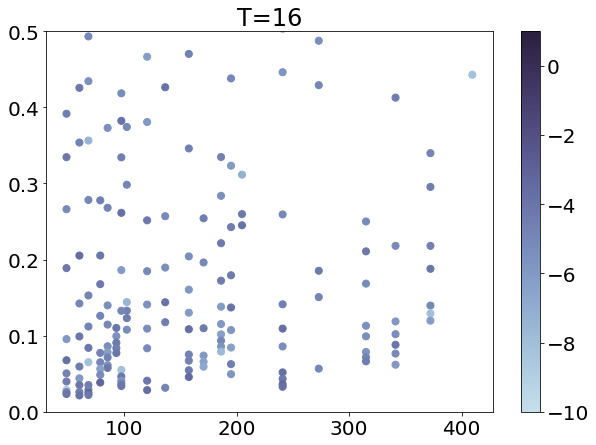

In [322]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))

cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
plt.title('T={T}'.format(T=T))

# f, ax = plt.subplots()
plt.scatter(x_list, y_list, c=z_list, s=50, cmap=cmap)
# plt.xlim(0, 200)
plt.ylim(0, 0.5)

plt.colorbar()